## Import Required Packages

In [34]:
# # install nanum font
import  matplotlib.font_manager  as fm
import  matplotlib.pyplot  as plt

plt.rc("font", family= 'Nanum Gothic')
plt.rcParams['axes.unicode_minus'] = False
font_path = "../fonts/NanumGothic.ttf"


bash
- pip3 install konlpy: 한국어 처리를 위한 python library
- pip3 install nltk: 자연어 처리를 위한 python library (tokenize, pos-tagging, parser 등 제공)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

import re
from konlpy.tag import Komoran
import numpy as np
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

[nltk_data] Downloading package punkt to /Users/minair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/minair/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/minair/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/minair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Load

In [36]:
path = "../data/test-data.csv"

df = pd.read_csv(path)

In [37]:
df.head()

,title,label
0,[국제교류팀] 계약직원 모집,1
1,24-2학기 강사 추가 채용,0
2,현대해상 마음한글 글샘 모집,1
3,[국제교류팀] 2025학년도 1학기 파견 국제교류 프로그램 선발 안내,1
4,2024학년도 2학기 국민대학교 창업동아리 모집 안내(~8/21),1


In [38]:
#label 값에 null값 확인
df['label'].isnull().sum()

np.int64(0)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   976 non-null    object
 1   label   976 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


## EDA

### 1. 결측치 확인+중복제거

In [40]:
df[df.duplicated()]

,title,label
51,「2024 대구정원박람회」 학생정원 참여작품 모집공모 안내,1
144,영상정보처리기기(CCTV) 설치에 따른 의견수렴(행정예고),0
148,[미래차SW인력양성사업단] 연구원 모집,1
153,영상정보처리기기(CCTV) 설치에 따른 의견수렴(행정예고),0
271,서울대학교 수의과대학 자체직원(기간제) 수의사 채용 공고,1
...,...,...
953,S-INNOVATION 창업보육센터 신규입주기업 모집공고,0
964,서울대학교 융합과학기술대학원 DYROS 로봇스쿨,1
965,서울대학교 DYROS 로보틱스 부트캠프 안내,1
966,S-INNOVATION 창업보육센터 신규입주기업 모집공고,0


In [41]:
df.drop_duplicates(inplace = True)

In [42]:
df

,title,label
0,[국제교류팀] 계약직원 모집,1
1,24-2학기 강사 추가 채용,0
2,현대해상 마음한글 글샘 모집,1
3,[국제교류팀] 2025학년도 1학기 파견 국제교류 프로그램 선발 안내,1
4,2024학년도 2학기 국민대학교 창업동아리 모집 안내(~8/21),1
...,...,...
971,제9회「서울대학교 사회봉사상」후보 추천 공고,1
972,제12회「서울대학교 발전공로상」후보 추천 공고,1
973,2019학년도 융합과학기술대학원 신입생 후기모집,0
974,제73회 전기 학위수여식 및 2019학년도 입학식 안내,0


### 2. class의 균형성 확인

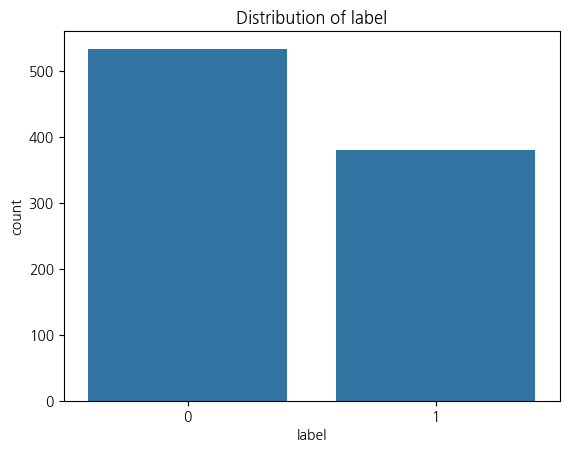

In [43]:
#label 분포 확인
sns.countplot(x='label', data=df)
plt.title('Distribution of label')
plt.show()

In [44]:
df['label'].value_counts()

label
0    533
1    380
Name: count, dtype: int64

### 3. title length 분포 파악

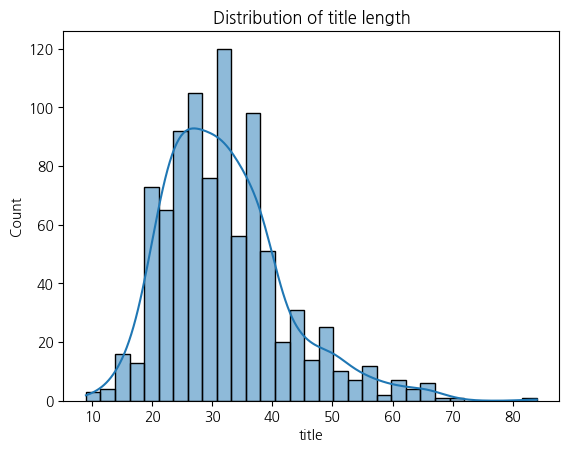

In [45]:
#title에 대한 eda

sns.histplot(df['title'].str.len(), kde=True)
plt.title('Distribution of title length')
plt.show()

In [46]:
df['title'].str.len().median()

np.float64(31.0)

In [47]:
df[df["label"] == 0]['title'].str.len().median()

np.float64(31.0)

In [48]:
df[df["label"] == 1]['title'].str.len().median()

np.float64(30.0)

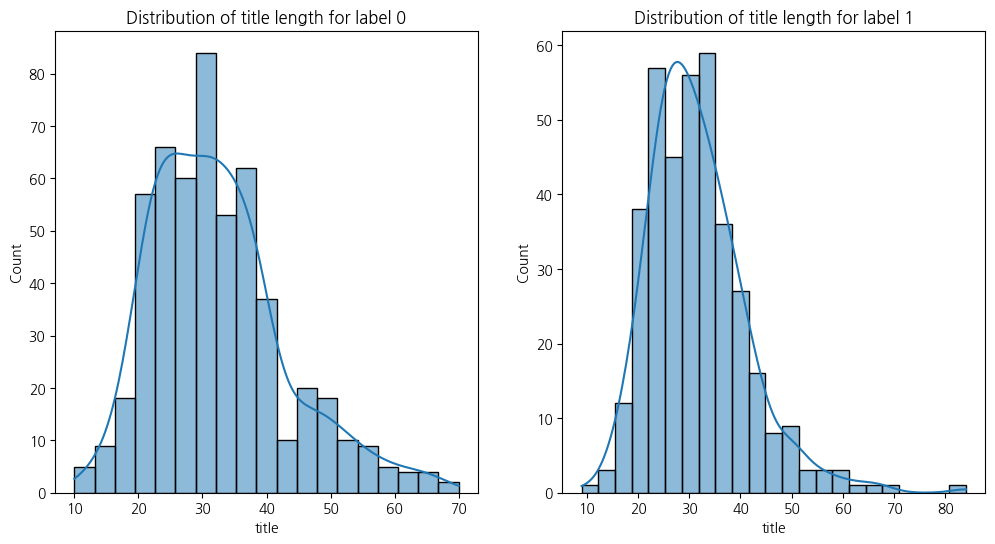

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#label= 0일 때의 텍스트 길이 분포
sns.histplot(df[df['label'] == 0]['title'].str.len(), kde=True, ax = ax[0])
ax[0].set_title('Distribution of title length for label 0')

#label= 1일 때의 텍스트 길이 분포
sns.histplot(df[df['label'] == 1]['title'].str.len(), kde=True, ax = ax[1])
ax[1].set_title('Distribution of title length for label 1')

plt.show()

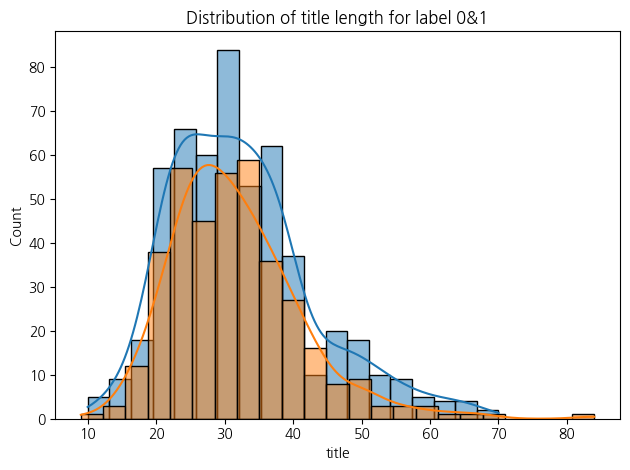

In [50]:
#label= 0일 때의 텍스트 길이 분포 (blue)
sns.histplot(df[df['label'] == 0]['title'].str.len(), kde=True)


#label= 1일 때의 텍스트 길이 분포 (orange)
sns.histplot(df[df['label'] == 1]['title'].str.len(), kde=True)
plt.title('Distribution of title length for label 0&1')

plt.tight_layout()
plt.show()

### 4. word cloud (불용어 제거 x ver)

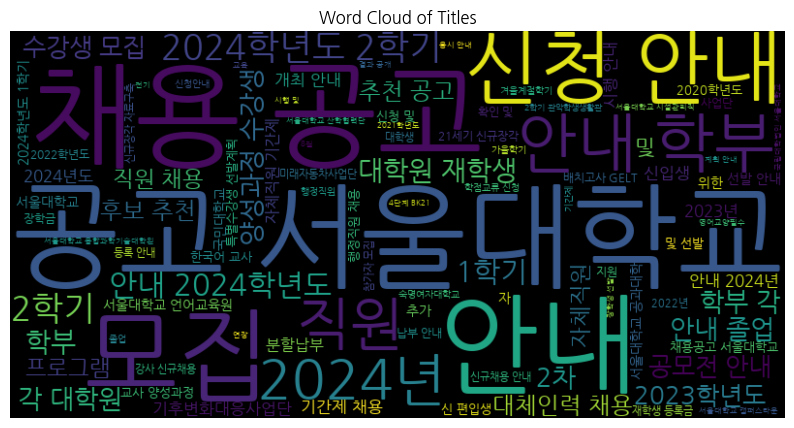

In [51]:
#데이터셋 전체 word cloud

all_words = ' '.join([text for text in df['title']])
wordcloud = WordCloud(font_path=font_path, width=800, height=400, max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Titles')
plt.show()


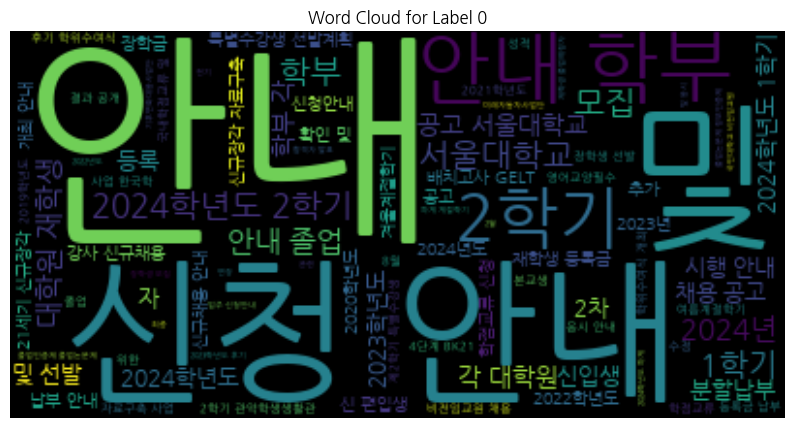

In [52]:
#label = 0 의 word cloud
text_label_0 = ' '.join(df[df['label'] == 0]['title'].astype(str))
wordcloud_label_0 = WordCloud(font_path=font_path, background_color='black').generate(text_label_0)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.title('Word Cloud for Label 0')
plt.axis('off')

plt.show()

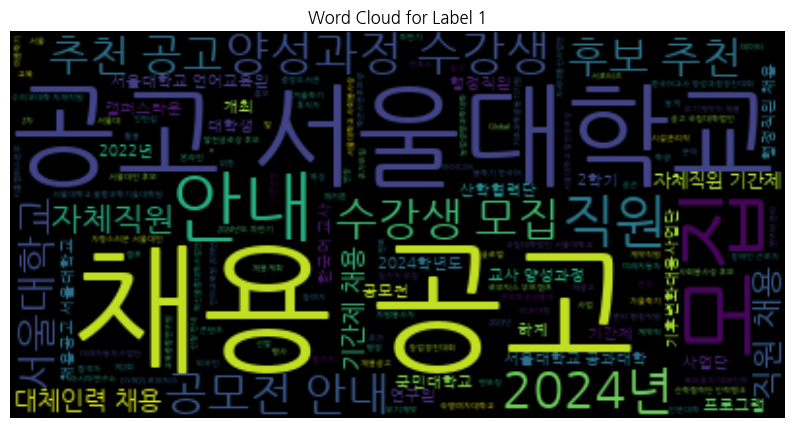

In [53]:
#label = 1 의 word cloud
text_label_1 = ' '.join(df[df['label'] == 1]['title'].astype(str))
wordcloud_label_1 = WordCloud(font_path=font_path, background_color='black').generate(text_label_1)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.title('Word Cloud for Label 1')
plt.axis('off')

plt.show()

## Preprocessing

In [56]:
#영문자와 한글만 title에 남기기

df['title'] = df['title'].str.replace('[^a-z|A-Z|ㄱ-ㅎ|가-힣|]', ' ', regex = True)

In [57]:
df['title']

0                              국제교류팀  계약직원 모집
1                                 학기 강사 추가 채용
2                             현대해상 마음한글 글샘 모집
3       국제교류팀      학년도  학기 파견 국제교류 프로그램 선발 안내
4            학년도  학기 국민대학교 창업동아리 모집 안내       
                        ...                  
971                  제 회 서울대학교 사회봉사상 후보 추천 공고
972                 제  회 서울대학교 발전공로상 후보 추천 공고
973                    학년도 융합과학기술대학원 신입생 후기모집
974            제  회 전기 학위수여식 및     학년도 입학식 안내
975            국민권익위원회 주관     년도 부패방지 시책평가 결과
Name: title, Length: 913, dtype: object

In [58]:
# 영어 알파벳 (대소문자)를 인식
eng = re.compile(r'[a-zA-Z]')

In [59]:
# lambda 함수를 사용해서 text의 탐지된 x(영어)를 lowercase로 바꿔준다.
def lowercase(text):
    return re.sub(r'[a-zA-Z]', lambda x: x.group().lower(), text)

In [60]:
df['title'] = df['title'].apply(lowercase)

In [61]:
# 크롤링해온 학교 명을 95% 정도 삭제하고, 5% 정도는 남겨두고자 함.
# 제거할 단어와 확률

school_words = ['국민대학교', '국민대', '귝민', '서울대학교', '서울대', '서울', '숙명여자대학교', '숙명여대', '숙대', '숙명']

probability = 0.95

# 단어 제거 함수
def probabilistic_remove(word, text, probability):
    if np.random.rand() < probability:
        return text.replace(word, '')
    return text

# 각 행에 대해 school words를 95% 확률로 제거
for school_word in school_words:
    df['title'] = df['title'].apply(lambda x: probabilistic_remove(school_word, x, probability))


In [62]:
# 형태소 분석 및 불용어 제거 함수

def preprocess(text):
    stop_words = ['의','가','이','은','들','는','걍','과','들','과','으로','도','을',
                 '를','으로','자','에','와','한','하다','에서','에게', '및', '연도', '년',
                 '년도', '학기', 'ㄴ' '학년도', '회', '상반기', '하반기', '년대', '학년',
                 '오후', '오전', '오늘', '내일', '회차', '개월', '주년', '종료', 'th', 'st', 'nd', "'s", '접수', '기한', '연장',
                  '월', '어', '다', '까지', '제', '등', '등등', '몇', '면', '각', '각각', '마감','공통', '만료',
                  '여', '대', '백양']

    komoran = Komoran(userdic = '../preprocessing/user_dictionary.txt') # user_dictionary를 설정해 사용자가 단어를 정의
    lemmatizer = WordNetLemmatizer() # 영어 표제화: 단어를 기본형으로 변환

    token_list = []

    for sentence in text :
       sentence = sentence.strip()
       if not sentence:
           token_list.append('')
           continue

       words = sentence.split()
       sentense_list = []

       for word in words :
          if eng.match(word) :
              tokens_word = word_tokenize(word)
              tokens_pos = pos_tag(tokens_word)
              for w, pos in tokens_pos:
                  if pos.startswith('N'): # 명사
                      lemma = lemmatizer.lemmatize(w, pos='n') # 기본형으로 변환
                  elif pos.startswith('V'): # 동사
                      lemma = lemmatizer.lemmatize(w, pos='v') # 기본형으로 변환
                  elif pos.startswith('J'): # 형용사
                      lemma = lemmatizer.lemmatize(w, pos='a') # 기본형으로 변환
                  elif pos.startswith('R'): # 부사
                      lemma = lemmatizer.lemmatize(w, pos='r') # 기본형으로 변환
                  else :
                      continue
                  sentense_list.append(lemma)

          else : # 한국어인 경우
              nouns = komoran.nouns(word)
              sentense_list.extend(nouns)
       token = [t for t in sentense_list if t not in stop_words]
       token_list.append(' '.join(token))
    return token_list

In [63]:
df['processed_title'] = preprocess(df['title'])

In [64]:
df

,title,label,processed_title
0,국제교류팀 계약직원 모집,1,국제 교류 팀 계약직원 모집
1,학기 강사 추가 채용,0,강사 추가 채용
2,현대해상 마음한글 글샘 모집,1,현대해상 마음 한글 글 샘 모집
3,국제교류팀 학년도 학기 파견 국제교류 프로그램 선발 안내,1,국제 교류 팀 파견 국제 교류 프로그램 선발 안내
4,학년도 학기 창업동아리 모집 안내,1,창업 동아리 모집 안내
...,...,...,...
971,제 회 학교 사회봉사상 후보 추천 공고,1,학교 사회봉사 후보 추천 공고
972,제 회 발전공로상 후보 추천 공고,1,발전 공로상 후보 추천 공고
973,학년도 융합과학기술대학원 신입생 후기모집,0,융합과학 기술대학 원 신입생 후기 모집
974,제 회 전기 학위수여식 및 학년도 입학식 안내,0,전기 학위 수여식 입학식 안내


In [65]:
df.to_csv("preprocessed_title_test.csv")

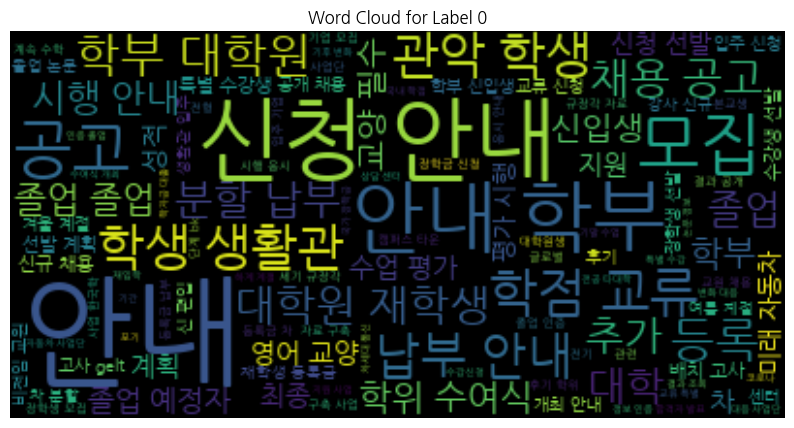

In [66]:
#label = 0 의 word cloud
text_label_0 = ' '.join(df[df['label'] == 0]['processed_title'].astype(str))
wordcloud_label_0 = WordCloud(font_path=font_path, background_color='black').generate(text_label_0)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.title('Word Cloud for Label 0')
plt.axis('off')

plt.show()

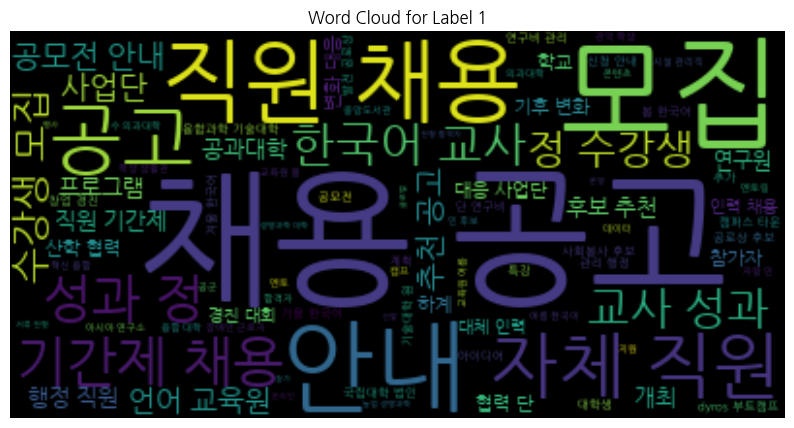

In [166]:
#label = 1 의 word cloud
text_label_1 = ' '.join(df[df['label'] == 1]['processed_title'].astype(str))
wordcloud_label_1 = WordCloud(font_path=font_path, background_color='black').generate(text_label_1)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.title('Word Cloud for Label 1')
plt.axis('off')

plt.show()

In [167]:
# 모든 텍스트에서 단어 빈도 계산
all_words = ' '.join(df['processed_title']).split()
all_word_counts = Counter(all_words)
top_50_words = all_word_counts.most_common(50)

print("전체 데이터에서 상위 50개 용어:")
print(top_50_words)

전체 데이터에서 상위 50개 용어:
[('안내', 378), ('공고', 227), ('채용', 198), ('모집', 139), ('신청', 90), ('학부', 90), ('직원', 67), ('졸업', 50), ('사업단', 40), ('학생', 40), ('선발', 36), ('수강생', 32), ('재학생', 31), ('납부', 30), ('기간제', 30), ('계획', 28), ('시행', 28), ('관악', 27), ('생활관', 27), ('입주', 27), ('대학원', 26), ('등록금', 25), ('공모전', 25), ('개최', 25), ('자체', 25), ('추가', 24), ('학점', 24), ('교류', 24), ('한국어', 23), ('차', 22), ('공개', 22), ('성과', 21), ('정', 21), ('신입생', 21), ('추천', 21), ('사업', 20), ('교사', 20), ('후기', 19), ('분할', 19), ('하계', 18), ('프로그램', 17), ('장학생', 17), ('등록', 17), ('언어', 17), ('교육원', 17), ('예정자', 17), ('학위', 16), ('수여식', 16), ('교원', 16), ('결과', 16)]


In [168]:
# 레이블 0에서 많이 쓰인 용어
label_0_words = ' '.join(df[df['label'] == 0]['processed_title']).split()
label_0_word_counts = Counter(label_0_words)
top_25_words_label_0 = label_0_word_counts.most_common(25)

# 레이블 1에서 많이 쓰인 용어
label_1_words = ' '.join(df[df['label'] == 1]['processed_title']).split()
label_1_word_counts = Counter(label_1_words)
top_25_words_label_1 = label_1_word_counts.most_common(25)

print("레이블 0에서 많이 쓰인 상위 25개 용어:")
print(top_25_words_label_0)

print("레이블 1에서 많이 쓰인 상위 25개 용어:")
print(top_25_words_label_1)

레이블 0에서 많이 쓰인 상위 25개 용어:
[('안내', 302), ('학부', 90), ('신청', 82), ('공고', 56), ('채용', 52), ('졸업', 50), ('모집', 43), ('선발', 33), ('학생', 31), ('납부', 30), ('재학생', 29), ('시행', 27), ('입주', 27), ('대학원', 26), ('등록금', 25), ('학점', 24), ('교류', 24), ('계획', 23), ('관악', 23), ('생활관', 23), ('공개', 21), ('차', 20), ('추가', 19), ('후기', 19), ('분할', 19)]
레이블 1에서 많이 쓰인 상위 25개 용어:
[('공고', 171), ('채용', 146), ('모집', 96), ('안내', 76), ('직원', 67), ('기간제', 30), ('공모전', 25), ('사업단', 25), ('자체', 25), ('성과', 21), ('정', 21), ('한국어', 20), ('교사', 20), ('수강생', 20), ('추천', 18), ('언어', 16), ('교육원', 16), ('후보', 16), ('행정', 15), ('프로그램', 14), ('공과대학', 14), ('개최', 13), ('연구원', 11), ('참가자', 10), ('하계', 10)]


In [169]:
#frequent word 시각화

# 레이블 0에서 많이 쓰인 상위 25개 단어 빈도 데이터프레임
top_25_label_0_df = pd.DataFrame(top_25_words_label_0, columns=['Word', 'Frequency'])

# 레이블 1에서 많이 쓰인 상위 25개 단어 빈도 데이터프레임
top_25_label_1_df = pd.DataFrame(top_25_words_label_1, columns=['Word', 'Frequency'])

# 수평 막대 그래프 함수
def plot_horizontal_bar(data, title, color):
    plt.figure(figsize=(10, 8))
    plt.barh(data['Word'], data['Frequency'], color=color)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

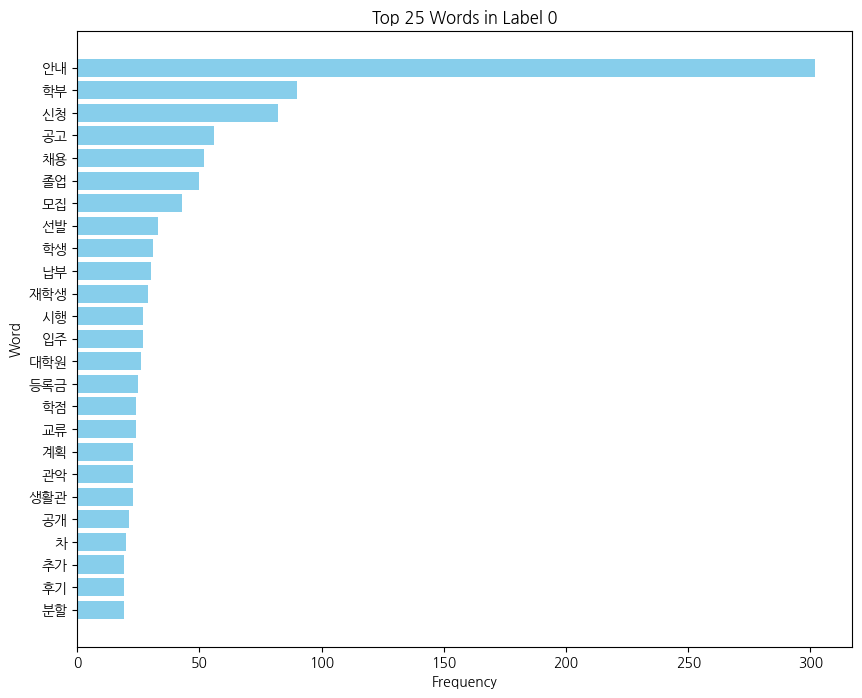

In [170]:
# 레이블 0에서 상위 25개 단어 빈도 시각화
plot_horizontal_bar(top_25_label_0_df, 'Top 25 Words in Label 0', 'skyblue')

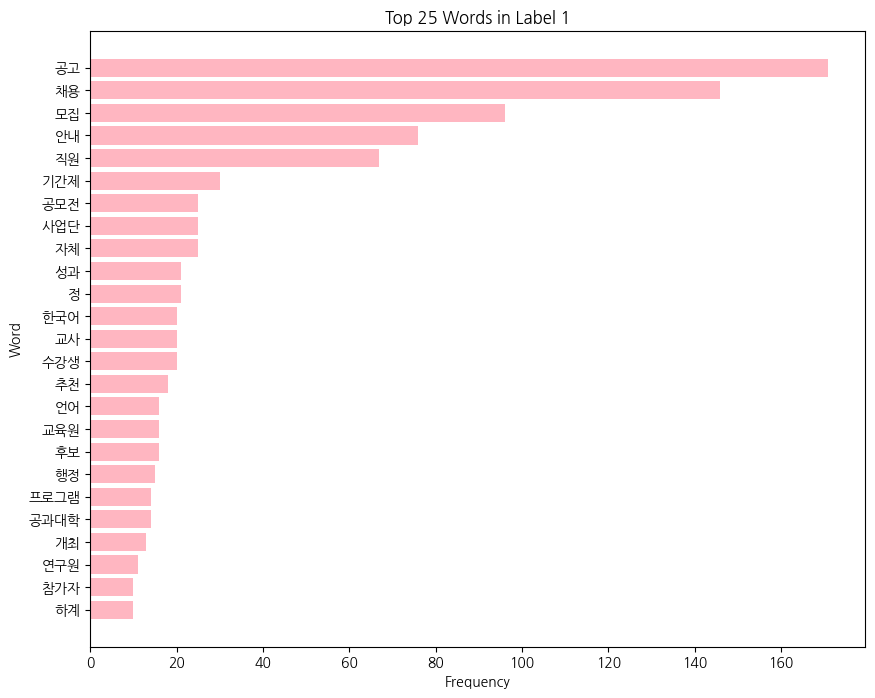

In [171]:
# 레이블 1에서 상위 25개 단어 빈도 시각화
plot_horizontal_bar(top_25_label_1_df, 'Top 25 Words in Label 1', 'lightpink')